In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q keras

In [4]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import keras
from keras.layers import LeakyReLU
import splitfolders
from keras.layers import*
from keras.models import*
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
dir = 'datasets'

catagories = ['Corn___Common_Rust','Corn___Gray_Leaf_Spot','Corn___Healthy','Corn___Northern_Leaf_Blight','Potato___Early_Blight',
				'Potato___Healthy', 'Potato___Late_Blight','Rice___Brown_Spot','Rice___Healthy','Rice___Leaf_Blast','Rice___Neck_Blast',
				'Wheat___Brown_Rust','Wheat___Healthy','Wheat___Yellow_Rust']


In [8]:
data = []

path = '/content/drive/MyDrive/datasets'
#splitfolders.ratio(path,output="/content/drive/MyDrive/datacr",seed=58, ratio=(.8,.1, .1), group_prefix=None, move=False)



train=ImageDataGenerator(rescale=1/255)
valdata=ImageDataGenerator(rescale=1/255)
train_dataset=train.flow_from_directory('/content/drive/MyDrive/datacr/train',target_size=(128,128), batch_size=64,class_mode='categorical')
val_dataset = valdata.flow_from_directory('/content/drive/MyDrive/datacr/val', target_size=(128,128), batch_size=32,class_mode='categorical')



Found 16513 images belonging to 19 classes.
Found 2059 images belonging to 19 classes.


In [9]:
from keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
base_model=DenseNet201(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

for layer in base_model.layers:
    layer.trainable = False
x=base_model.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(19,activation='softmax')(x) #FC-layer


74850304/74836368 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.models import Model
model=Model(inputs=base_model.input,outputs=preds)
print(base_model.input.shape)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
checkpoint_filepath = '/tmp/checkpoint'
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

(None, 128, 128, 3)


In [11]:
model.summary()
checkpoint_filepath = '/tmp/checkpoint'
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_recall',
    mode='max',
    save_best_only=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [12]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

hist = model.fit(train_dataset, validation_data= val_dataset,epochs=20,callbacks=[cp])

Epoch 1/20
259/259 [==============================] - 4091s 16s/step - loss: 0.6704 - accuracy: 0.7809 - recall: 0.7537 - precision: 0.8146 - val_loss: 0.2710 - val_accuracy: 0.8970 - val_recall: 0.8834 - val_precision: 0.9118
Epoch 2/20
259/259 [==============================] - 217s 840ms/step - loss: 0.3954 - accuracy: 0.8559 - recall: 0.8419 - precision: 0.8713 - val_loss: 0.2416 - val_accuracy: 0.9150 - val_recall: 0.9068 - val_precision: 0.9233
Epoch 3/20
259/259 [==============================] - 206s 795ms/step - loss: 0.3248 - accuracy: 0.8796 - recall: 0.8650 - precision: 0.8916 - val_loss: 0.2243 - val_accuracy: 0.9174 - val_recall: 0.9116 - val_precision: 0.9265
Epoch 4/20
259/259 [==============================] - 206s 793ms/step - loss: 0.2981 - accuracy: 0.8881 - recall: 0.8751 - precision: 0.9017 - val_loss: 0.2124 - val_accuracy: 0.9257 - val_recall: 0.9165 - val_precision: 0.9296
Epoch 5/20
259/259 [==============================] - 203s 783ms/step - loss: 0.2734 - ac

# New Section

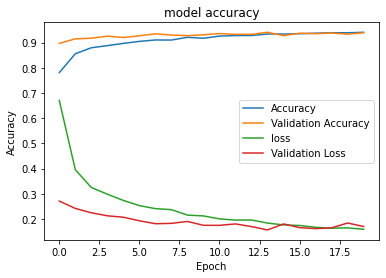

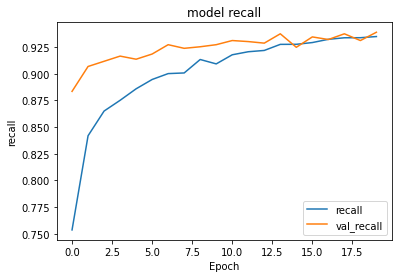

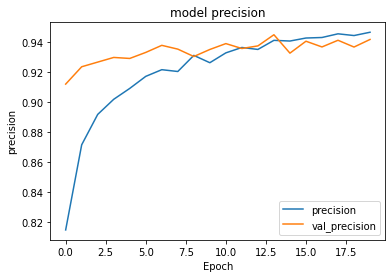

In [13]:

#hist = model.fit(train_dataset, validation_data= val_dataset,epochs=5,callbacks=[cp])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title("model recall")
plt.ylabel("recall")
plt.xlabel("Epoch")
plt.legend(["recall","val_recall"])
plt.show()


plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title("model precision")
plt.ylabel("precision")
plt.xlabel("Epoch")
plt.legend(["precision","val_precision"])
plt.show()

model.save('/content/drive/MyDrive/densenetmodel201')

In [14]:
test=ImageDataGenerator(rescale=1/255)

test_dataset=train.flow_from_directory('/content/drive/MyDrive/datacr/test',target_size=(128,128), batch_size=64,class_mode='categorical')

result = model.evaluate(test_dataset,batch_size=64)

Found 2079 images belonging to 19 classes.
33/33 [==============================] - 442s 14s/step - loss: 0.1621 - accuracy: 0.9404 - recall: 0.9351 - precision: 0.9446


In [15]:
model.save('/content/drive/MyDrive/densenetmodel201')